# Plot figures for parametrized tests of GW generation from posterior datasets

In [5]:
%matplotlib inline
import numpy as np
import matplotlib
import h5py
#import cPickle
import pickle as cPickle
import matplotlib.pyplot as plt
import math

In [14]:
#!/usr/bin/env python3
"""
Colab-friendly tool to inspect PGen (PGen.tgz) contents and compute a1 posteriors.

What this does:
 1) Extracts the uploaded /content/PGen.tgz (if present) into /content/pgen_extracted
 2) Finds .hdf5 / .h5 files and prints a readable recursive listing of groups/datasets.
 3) For datasets that look like posterior samples, prints available field/column names
    and shows a few sample rows so you can identify the correct parameter names
    (e.g., m1, m2, psi4, delta_psi4).
 4) Provides a helper function compute_a1_from_hdf5(...) which, given the exact
    column names for m1, m2, phi4, dphi4, computes a1 samples, saves CSV and
    produces violin / KDE plots.

How to use in Colab:
 - Upload PGen.tgz to /content (your screenshot shows it is there).
 - Paste this entire file into a single Colab code cell and run it.
 - The cell will:
     * inspect the archive and print structure and field-name suggestions
     * if it finds posterior arrays it will print candidate column names
 - After inspection, copy one example HDF5 path and the exact field names
   (e.g. 'posterior_samples/psi4' or 'samples/phi4') and then call:
     compute_a1_from_hdf5("/content/pgen_extracted/.../GW150914_....hdf5",
                          col_m1="mass1_injection", col_m2="mass2_injection",
                          col_phi4="psi4", col_dphi4="dpsi4",
                          outdir="/content/pgen_a1_output")
 - The helper will write CSV(s) and plots to outdir.

You can re-run inspection until you are satisfied with the field selections.

Requirements (Colab):
  - h5py, numpy, pandas, matplotlib, seaborn (the cell will attempt to install missing packages)
"""

# --- Colab-friendly package install (no-op if already installed) ---
import sys, subprocess, pkgutil
def pip_install(packages):
    to_install = []
    for pkg in packages:
        name = pkg.split("==")[0]
        # use importlib.util.find_spec to avoid deprecated pkgutil.find_loader
        try:
            import importlib.util
            spec = importlib.util.find_spec(name)
            if spec is None:
                to_install.append(pkg)
        except Exception:
            to_install.append(pkg)
    if to_install:
        print("Installing:", to_install)
        subprocess.check_call([sys.executable, "-m", "pip", "install", *to_install])
    else:
        print("All required packages already installed.")

pip_install(["h5py", "numpy", "pandas", "matplotlib", "seaborn"])

# --- imports ---
import os
from pathlib import Path
import tarfile
import tempfile
import shutil
from typing import Optional, List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import h5py
except Exception as e:
    raise RuntimeError("h5py is required. Install with pip.") from e

# --- helper utilities ---

def extract_tgz_if_needed(tgz_path: Path, extract_to: Path) -> Path:
    """
    Extract tgz_path into extract_to (create if needed). Returns extract_to.
    """
    extract_to.mkdir(parents=True, exist_ok=True)
    print(f"Extracting {tgz_path} -> {extract_to} ...")
    # If tarfile warns about extraction filter in Python 3.14+, ignore for now
    with tarfile.open(tgz_path, "r:gz") as tf:
        tf.extractall(extract_to)
    print("Extraction complete.")
    return extract_to

def find_hdf5_files(root: Path) -> List[Path]:
    exts = {".h5", ".hdf5"}
    files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    # Prefer GWTC-1 events if present (filter)
    if files:
        return files
    # fallback to other sample files (txt/csv) if no HDF5
    return []

def print_hdf5_structure(h5path: Path, max_items: int = 20) -> None:
    """
    Print a readable tree of the HDF5 file groups/datasets and for structured
    datasets print dtype names. Also print examples (first rows).
    """
    print("\n" + "="*80)
    print(f"HDF5 file: {h5path}")
    print("="*80)
    with h5py.File(h5path, "r") as f:
        def recurse(name, obj):
            indent = "  " * (name.count("/") + (0 if name == "" else 0))
            if isinstance(obj, h5py.Group):
                print(f"{'  ' * (name.count('/'))}- GROUP: {name or '/'}")
                # show up to 10 children
                for k in list(obj.keys())[:max_items]:
                    recurse(k if name == "" else f"{name}/{k}", obj[k])
            elif isinstance(obj, h5py.Dataset):
                ds = obj
                shape = ds.shape
                dtype = ds.dtype
                print(f"{'  ' * (name.count('/'))}- DATASET: {name} | shape={shape} dtype={dtype}")
                # If structured dtype (named columns), print field names and first few entries
                try:
                    arr = ds[()]
                    if hasattr(arr, "dtype") and arr.dtype.names:
                        print(f"{'  ' * (name.count('/'))}  structured fields: {list(arr.dtype.names)}")
                        # convert to pandas DataFrame for nicer display head()
                        df = pd.DataFrame({n: arr[n] for n in arr.dtype.names})
                        print(df.head(5).to_string(index=False))
                    elif arr.ndim == 2 and arr.shape[1] <= 30:
                        # try to print small 2D arrays as table
                        df = pd.DataFrame(arr)
                        print(df.head(5).to_string(index=False))
                    elif arr.ndim == 1 and arr.size <= 1000:
                        # show a slice
                        print(f"{'  ' * (name.count('/'))}  sample values: {arr[:5]}")
                except Exception as e:
                    print(f"{'  ' * (name.count('/'))}  (couldn't read dataset sample: {e})")

        # start recursion from root
        recurse("", f)

def guess_param_fields_in_hdf5(h5path: Path) -> Dict[str, List[str]]:
    """
    Heuristically search the HDF5 file for candidate column/field names that look like m1, m2, psi4, dpsi4.
    Returns dictionary mapping parameter -> list of candidate full paths (group/dataset names).
    """
    candidates = {"m1": [], "m2": [], "phi4": [], "dphi4": []}
    name_hints = {
        "m1": ["m1", "mass_1", "mass1", "m1_source", "mass_1_source", "m1_inspiral", "mass1_source"],
        "m2": ["m2", "mass_2", "mass2", "m2_source", "mass_2_source", "m2_inspiral"],
        "phi4": ["psi4", "phi4", "psi_4", "phi_4", "psi4_2pn", "psi4_inj"],
        "dphi4": ["dpsi4", "delta_psi4", "dphi4", "delta_phi4", "psi4_err"],
    }
    with h5py.File(h5path, "r") as f:
        def walk(name, obj):
            if isinstance(obj, h5py.Dataset):
                # dataset name only
                nm = name.lower()
                # if structured, check field names
                try:
                    arr = obj[()]
                    if hasattr(arr, "dtype") and arr.dtype.names:
                        for field in arr.dtype.names:
                            fld_lc = field.lower()
                            for key, hints in name_hints.items():
                                for hint in hints:
                                    if hint in fld_lc:
                                        candidates[key].append(f"{name}:{field}")
                    else:
                        # dataset might be 2D with columns unknown; include dataset name if hint matches
                        for key, hints in name_hints.items():
                            for hint in hints:
                                if hint in nm:
                                    candidates[key].append(name)
                except Exception:
                    # could be large or virtual dataset; still match name
                    for key, hints in name_hints.items():
                        for hint in hints:
                            if hint in nm:
                                candidates[key].append(name)
            elif isinstance(obj, h5py.Group):
                for k in obj:
                    walk(f"{name}/{k}" if name else k, obj[k])
        walk("", f)
    return candidates

def load_samples_from_hdf5(h5path: Path, dataset_path: str) -> Optional[pd.DataFrame]:
    """
    Given a dataset_path like "posterior_samples" or "group/dataset" or "dataset:field"
    return a pandas DataFrame if possible.
    """
    with h5py.File(h5path, "r") as f:
        if ":" in dataset_path:
            dspath, field = dataset_path.split(":", 1)
            ds = f[dspath]
            arr = ds[()]
            if hasattr(arr, "dtype") and arr.dtype.names and field in arr.dtype.names:
                # create DataFrame from structured array
                df = pd.DataFrame({n: arr[n] for n in arr.dtype.names})
                return df
            else:
                raise ValueError("Requested structured field but dataset doesn't contain it.")
        else:
            # dataset_path points to a dataset (could be structured or 2D)
            ds = f[dataset_path]
            arr = ds[()]
            if hasattr(arr, "dtype") and arr.dtype.names:
                return pd.DataFrame({n: arr[n] for n in arr.dtype.names})
            elif arr.ndim == 2:
                # convert 2D to DF with integer column names
                df = pd.DataFrame(arr)
                return df
            elif arr.ndim == 1:
                # single-array (no column names) -> return single column df
                return pd.DataFrame({os.path.basename(dataset_path): arr})
    return None

# --- computation helper (user will call this once they know correct column names) ---
def compute_a1_from_df(df: pd.DataFrame, col_m1: str, col_m2: str,
                       col_phi4: str, col_dphi4: str,
                       outdir: Path, formula: str = "beta_mapping", k: float = -1.0/400.0) -> Dict[str, Any]:
    """
    Given a DataFrame with posterior samples, compute a1 array and save outputs.
    Returns a dictionary with results and writes files to outdir.
    """
    outdir.mkdir(parents=True, exist_ok=True)
    # ensure columns present
    for col in [col_m1, col_m2, col_phi4, col_dphi4]:
        if col not in df.columns:
            raise KeyError(f"Column {col} not found in DataFrame. Available: {list(df.columns)[:20]}")
    m1 = np.asarray(df[col_m1], dtype=float)
    m2 = np.asarray(df[col_m2], dtype=float)
    s = m1 + m2
    s = np.where(s == 0, np.nan, s)
    eta = (m1 * m2) / (s * s)
    phi4 = np.asarray(df[col_phi4], dtype=float)
    dphi4 = np.asarray(df[col_dphi4], dtype=float)

    if formula == "beta_mapping":
        # from your images mapping: a1 = +1/400 * phi4 * dphi4  (check sign convention)
        a1 = (1.0 / 400.0) * phi4 * dphi4
    elif formula == "default_images":
        a1 = k * phi4 * dphi4
    elif formula == "eta_times_psi4":
        a1 = eta * phi4
    else:
        raise ValueError("Unknown formula")

    # Save CSV
    outcsv = outdir / "a1_samples.csv"
    odf = pd.DataFrame({"m1": m1, "m2": m2, "eta": eta, "phi4": phi4, "dphi4": dphi4, "a1": a1})
    odf.to_csv(outcsv, index=False)
    print(f"Saved samples CSV to {outcsv}")

    # Plots: violin + KDE
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(data=[a1[np.isfinite(a1)]], inner="quartile", ax=ax)
    ax.axhline(0, color="k", linestyle="--", linewidth=0.8)
    ax.set_xticks([0])
    ax.set_xticklabels(["a1"])
    ax.set_ylabel("a1")
    plt.tight_layout()
    vfile = outdir / "a1_violin.png"
    fig.savefig(vfile, dpi=200)
    print(f"Saved violin plot to {vfile}")

    fig2, ax2 = plt.subplots(figsize=(6, 4))
    sns.kdeplot(a1[np.isfinite(a1)], bw_method="scott", ax=ax2)
    ax2.axvline(0, color="k", linestyle="--", linewidth=0.8)
    ax2.set_xlabel("a1")
    plt.tight_layout()
    kfile = outdir / "a1_kde.png"
    fig2.savefig(kfile, dpi=200)
    print(f"Saved KDE plot to {kfile}")

    # summary
    arr = a1[np.isfinite(a1)]
    summary = {"n_samples": int(arr.size), "median": float(np.median(arr)), "5%": float(np.percentile(arr, 5)), "95%": float(np.percentile(arr, 95))}
    pd.DataFrame([summary]).to_csv(outdir / "a1_summary.csv", index=False)
    print(f"Saved summary to {outdir/'a1_summary.csv'}")

    return {"a1": a1, "odf": odf, "summary": summary, "plots": {"violin": vfile, "kde": kfile}}

# --- top-level driver used in Colab ---
def inspect_and_report(tgz_path_str: str = "/content/PGen.tgz", extract_dir: str = "/content/pgen_extracted"):
    tgz_path = Path(tgz_path_str)
    if not tgz_path.exists():
        print(f"{tgz_path} not found. Upload PGen.tgz to Colab (Files panel) and re-run.")
        return
    extract_to = Path(extract_dir)
    # safe extraction: use extract_tgz_if_needed
    extract_tgz_if_needed(tgz_path, extract_to)
    # find hdf5 files
    h5_files = find_hdf5_files(extract_to)
    if not h5_files:
        print("No .h5/.hdf5 files found in extracted archive. If data are in other formats, examine files under", extract_to)
        # list top-level entries to help debug
        for p in extract_to.iterdir():
            print(" -", p)
        return
    print(f"Found {len(h5_files)} HDF5 files. Inspecting them one by one:")
    for h5 in h5_files:
        print_hdf5_structure(h5)
        cand = guess_param_fields_in_hdf5(h5)
        print("\nCandidate parameter fields discovered (heuristic):")
        for k, v in cand.items():
            print(f"  {k}: {v[:10]}")
        print("\n" + "-"*80 + "\n")

    # After inspection, user should call compute_a1_from_hdf5 using the discovered dataset & field names.

def compute_a1_from_hdf5(h5path: str, dataset_path_or_structured: str,
                         col_m1: str, col_m2: str, col_phi4: str, col_dphi4: str,
                         outdir: str = "/content/pgen_a1_output", formula: str = "beta_mapping", k: float = -1.0/400.0):
    """
    Convenience wrapper:
      - loads dataset (structured dataset or dataset group) into DataFrame
      - computes a1 using compute_a1_from_df
    dataset_path_or_structured:
      - if the HDF5 file has a structured dataset 'posterior' you can pass 'posterior' and then
        col_m1/col_m2/col_phi4/col_dphi4 should be field names inside that structured dataset.
      - if the dataset is a group of datasets, you may pass the dataset name or 'group/dataset'.
    """
    h5 = Path(h5path)
    if not h5.exists():
        raise FileNotFoundError(h5path)
    # Try to read a structured dataset if present with the given name
    df = None
    with h5py.File(h5, "r") as f:
        # If the user passed "group/dset:field" (format used by our guesser), support that
        if ":" in dataset_path_or_structured:
            # e.g. "posterior:psi4" -> treat as structured dataset
            dpath, field = dataset_path_or_structured.split(":", 1)
            ds = f[dpath]
            arr = ds[()]
            if hasattr(arr, "dtype") and arr.dtype.names:
                df = pd.DataFrame({n: arr[n] for n in arr.dtype.names})
            else:
                raise ValueError("Requested structured field but dataset doesn't contain named fields.")
        else:
            # dataset_path could be "posterior", or path to dataset group/dataset
            if dataset_path_or_structured in f:
                ds = f[dataset_path_or_structured]
                arr = ds[()]
                if hasattr(arr, "dtype") and arr.dtype.names:
                    df = pd.DataFrame({n: arr[n] for n in arr.dtype.names})
                elif arr.ndim == 2:
                    df = pd.DataFrame(arr)
                elif arr.ndim == 1:
                    df = pd.DataFrame({os.path.basename(dataset_path_or_structured): arr})
            else:
                # attempt to locate any structured dataset at top-level (common names)
                for candidate in ["posterior", "samples", "posterior_samples", "data"]:
                    if candidate in f:
                        ds = f[candidate]
                        arr = ds[()]
                        if hasattr(arr, "dtype") and arr.dtype.names:
                            df = pd.DataFrame({n: arr[n] for n in arr.dtype.names})
                            break
    if df is None:
        raise RuntimeError("Could not load samples into a DataFrame. Use inspect_and_report() to find dataset names.")
    # compute a1
    return compute_a1_from_df(df, col_m1, col_m2, col_phi4, col_dphi4, outdir=Path(outdir), formula=formula, k=k)

# === If this file is pasted & run in Colab cell, run inspection automatically ===
if __name__ == "__main__":
    print("Automatic inspection of /content/PGen.tgz (if present).")
    inspect_and_report("/content/PGen.tgz", "/content/pgen_extracted")
    print("\nWhen you see candidate fields above, call compute_a1_from_hdf5(...) with concrete names.")
    print("Example:")
    print("  compute_a1_from_hdf5('/content/pgen_extracted/.../GW150914.hdf5', 'posterior', col_m1='mass_1', col_m2='mass_2', col_phi4='psi4', col_dphi4='dpsi4', outdir='/content/pgen_a1_output')")

All required packages already installed.
Automatic inspection of /content/PGen.tgz (if present).
Extracting /content/PGen.tgz -> /content/pgen_extracted ...


/tmp/ipython-input-1721842648.py:85: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(extract_to)


Extraction complete.
Found 10 HDF5 files. Inspecting them one by one:

HDF5 file: /content/pgen_extracted/GW170818_GWTC-1-TGR.hdf5
- GROUP: /
- DATASET: dalpha_2_IMRP_posterior | shape=(22557,) dtype=[('costheta_jn', '<f8'), ('luminosity_distance_Mpc', '<f8'), ('right_ascension', '<f8'), ('declination', '<f8'), ('m1_detector_frame_Msun', '<f8'), ('m2_detector_frame_Msun', '<f8'), ('spin1', '<f8'), ('spin2', '<f8'), ('costilt1', '<f8'), ('costilt2', '<f8'), ('dalpha_2', '<f8')]
  structured fields: ['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension', 'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun', 'spin1', 'spin2', 'costilt1', 'costilt2', 'dalpha_2']
 costheta_jn  luminosity_distance_Mpc  right_ascension  declination  m1_detector_frame_Msun  m2_detector_frame_Msun    spin1    spin2  costilt1  costilt2  dalpha_2
   -0.639040               737.980113         5.947926     0.409121               40.321874               30.688487 0.186894 0.965944 -0.633909 -0.455

In [6]:
### GWTC-1 events and eligibility for parametrized inspiral (PI) and post-inspiral (PPI) tests (Table I)
events = ['GW150914', 'GW151226', 'GW170104', 'GW170608', 'GW170814', 'GW151012', 'GW170729', 'GW170809', 'GW170818', 'GW170823']
events_PI = ['GW150914', 'GW151226', 'GW170104', 'GW170608', 'GW170814']
events_PPI = ['GW150914', 'GW170104', 'GW170608', 'GW170814', 'GW151012', 'GW170729', 'GW170809', 'GW170818', 'GW170823']

### Testing-GR parameters to be analyzed for PI and PPI
params_PI = ["dphi_-2","dphi_0", "dphi_1", "dphi_2", "dphi_3", "dphi_4", "dphi_5l", "dphi_6", "dphi_6l", "dphi_7"]
params_PPI = ["dbeta_2", "dbeta_3", "dalpha_2", "dalpha_3", "dalpha_4"]
param_labels = {"dphi_-2":r"$\varphi_{-2}$",
              "dphi_0":r"$\varphi_0$",
              "dphi_1":r"$\varphi_1$",
              "dphi_2":r"$\varphi_2$",
              "dphi_3":r"$\varphi_3$",
              "dphi_4":r"$\varphi_4$",
              "dphi_5l":r"$\varphi_5^{(l)}$",
              "dphi_6":r"$\varphi_6$",
              "dphi_6l":r"$\varphi_6^{(l)}$",
              "dphi_7":r"$\varphi_7$",
              "dbeta_2":r"$\beta_2$",
              "dbeta_3":r"$\beta_3$",
              "dalpha_2":r"$\alpha_2$",
              "dalpha_3":r"$\alpha_3$",
              "dalpha_4":r"$\alpha_4$"}

### Use these to tweak the visible y-range in the violin plots
ylimits_PI = {'GW150914':[[-0.022,0.022],[-0.4,0.4],[-1.2,1.2],[-1.,1.],[-1.,1.],[-5.,5.],[-2.,2.],[-4.5,4.5],[-16.,16.],[-16.,16.]],
'GW170104':[[-0.066,0.066],[-1.5,1.5],[-3,3],[-3.6,3.6],[-3.6,3.6],[-10,10],[-13.5,13.5],[-13.5,13.5],[-40,40],[-48.,48.],[-48.,48.]],
'GW170608':[[-0.022,0.022],[-0.5,0.5],[-1.2,1.2],[-1.0,1.0],[-1.0,1.0],[-4.5,4.5],[-4.5,4.5],[-4.5,4.5],[-16.,16.],[-16.,16.]],
'GW170814':[[-0.022,0.022],[-0.5,0.5],[-1.2,1.2],[-1.2,1.2],[-1.2,1.2],[-4.5,4.5],[-4.5,4.5],[-4.5,4.5],[-16.,16.],[-16.,16.]],
'GW151226':[[-0.022,0.022],[-0.5,0.5],[-1.2,1.2],[-1.2,1.2],[-1.2,1.2],[-4.5,4.5],[-4.5,4.5],[-4.5,4.5],[-16.,16.],[-16.,16.]]}

ylimits_PPI ={'GW150914':[[-1.0,1.0],[-1.0,1.0],[-5.,5.],[-5.,5.],[-5.,5.]],
'GW170104':[[-1.0,1.0],[-1.0,1.0],[-10.,10.],[-10.,10.],[-10.,10.]],
'GW170608':[[-1.0,1.0],[-1.0,1.0],[-100.,100.],[-100.,100.],[-100.,100.]],
'GW170814':[[-1.0,1.0],[-1.0,1.0],[-10.,10.],[-10.,10.],[-10.,10.]],
'GW151012':[[-8.,8.],[-8.,8.],[-100,100.],[-100.,100.],[-100.,100.]],
'GW170729':[[-1.0,1.0],[-1.0,1.0],[-10.,10.],[-10.,10.],[-10.,10.]],
'GW170809':[[-1.0,1.0],[-1.0,1.0],[-10.,10.],[-10.,10.],[-10.,10.]],
'GW170818':[[-1.0,1.0],[-1.0,1.0],[-10.,10.],[-10.,10.],[-10.,10.]],
'GW170823':[[-1.0,1.0],[-1.0,1.0],[-10.,10.],[-10.,10.],[-10.,10.]]}


In [7]:
def get_ul(data):
    ### Retrieve one-sided 90% upper limit for given 1D posterior *simplified version*
    idx90 = int (math.ceil(0.9*len(data)))
    ul_90 = np.sort(abs(data))[idx90]

    return ul_90


def get_event_data(event):
    '''
    Load the posterior samples of all non-GR parameters tested for <event>
    Returns a dictionary of posteriors for each available parameter and model
    '''
    event_data = {}

    filename = event + "_GWTC-1-TGR.hdf5"

    with h5py.File(filename, 'r') as datafile:
        ### Populate list of available non-GR test parameters for this GW event
        tgrparlist = []
        if event in events_PI:
            tgrparlist += params_PI
        if event in events_PPI:
            tgrparlist += params_PPI

        ### Loop through non-GR test parameters
        for tgrpar in tgrparlist:
            event_data[tgrpar]={}

            ### IMRPhenomPv2 available for all parameters (PI+PPI)
            ### SEOBNRv4_ROM available for parametrized-inspiral (PI) only
            models = ["IMRP"]
            if tgrpar in params_PI:
                models += ["SEOB"]

            ### Loop through available models
            for model in models:

                ### Load dataset and extract 1D posteriors of non-GR parameter
                dataset_name = "%s_%s_posterior" % (tgrpar, model)
                data = datafile[dataset_name]
                tgrdata = data[tgrpar]
                # print event, tgrpar, "\t", model, len(tgrdata)
                event_data[tgrpar][model] = tgrdata

    return event_data

## Individual measurements of non-GR parameters for each GW event [Fig. 8, 9]

<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipython-input-1747594706.py:23: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if model is "IMRP":


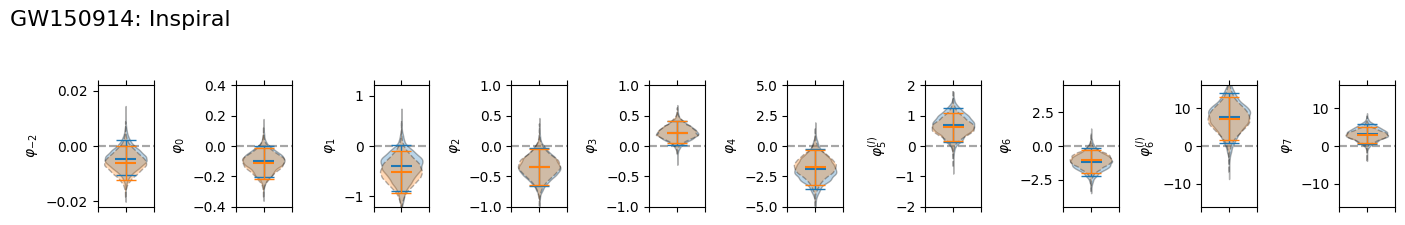

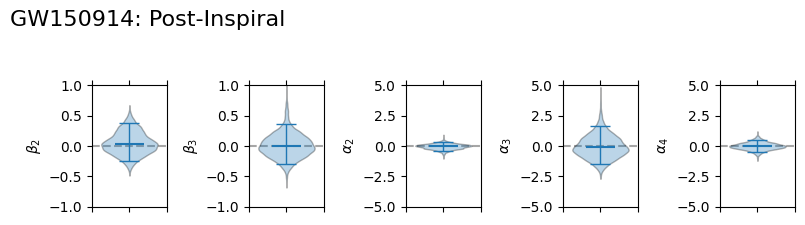

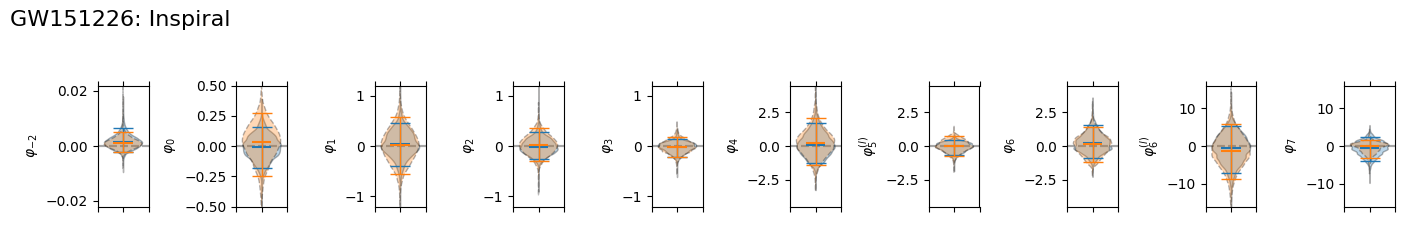

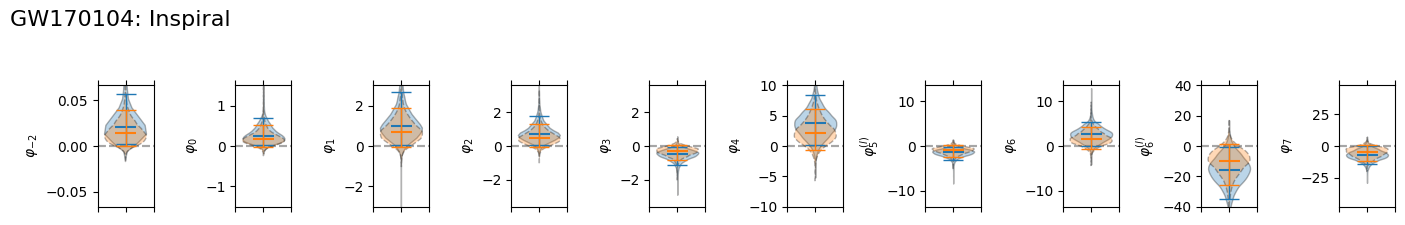

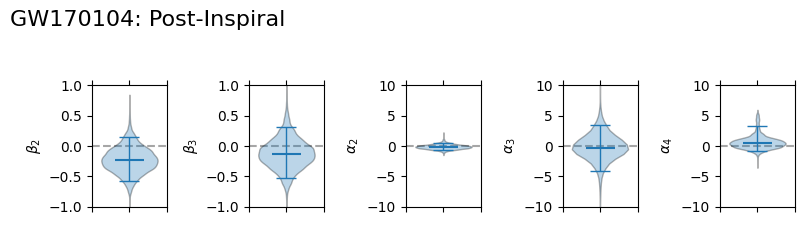

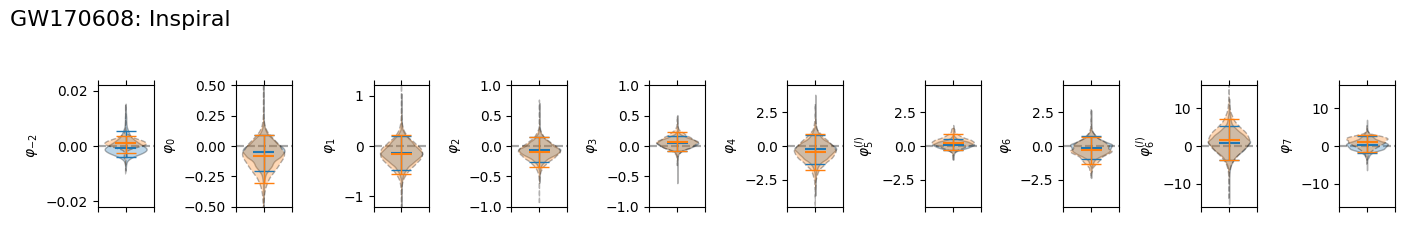

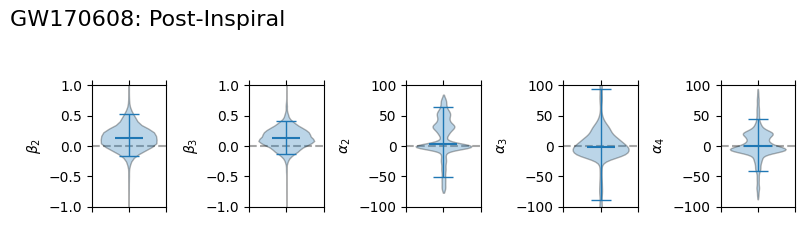

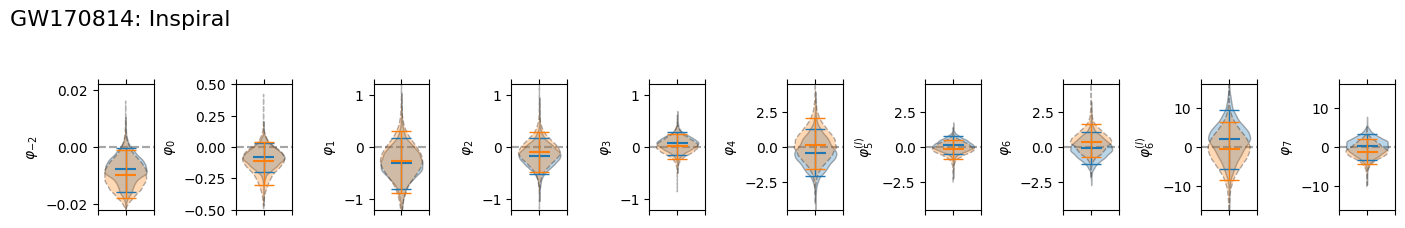

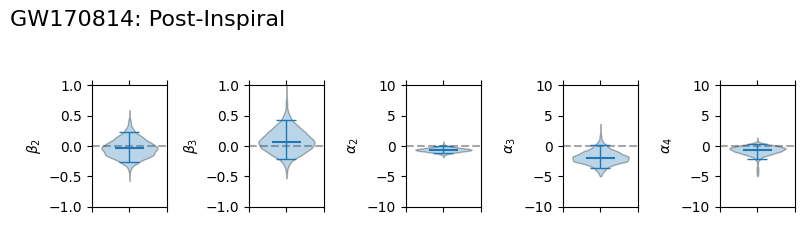

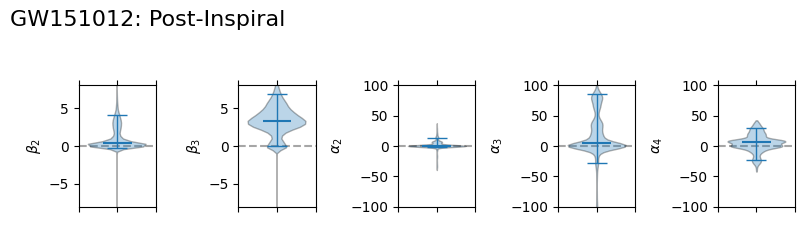

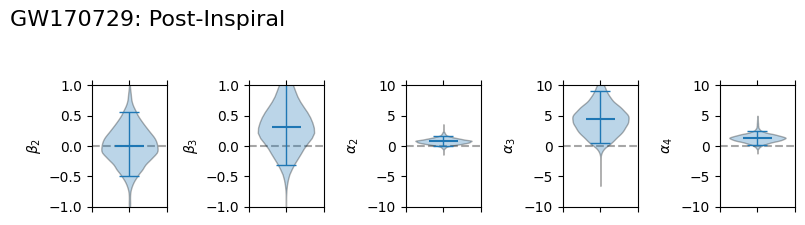

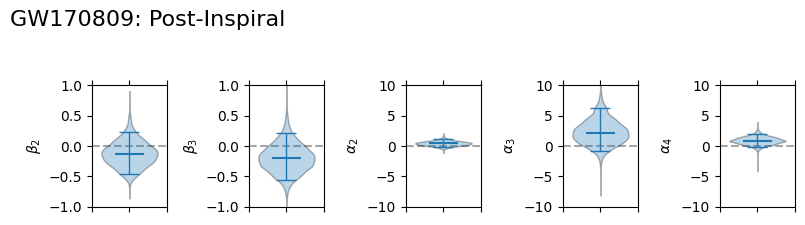

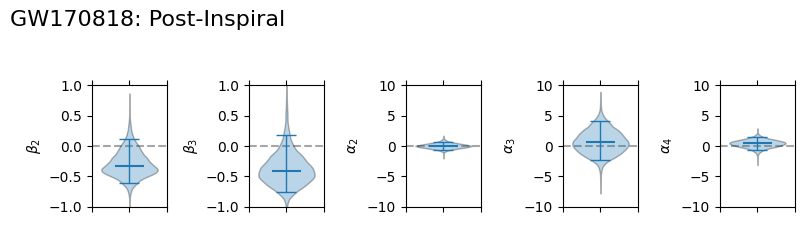

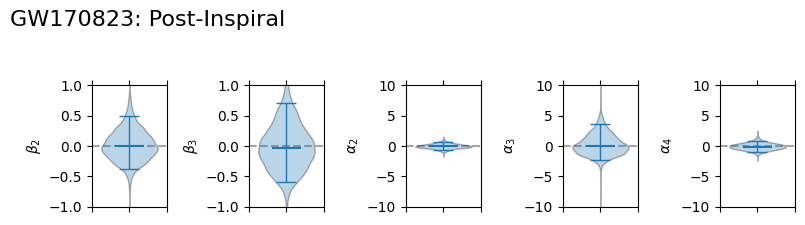

In [8]:
### Loop over events and available parameters and models, draw violin plots and populate 90% upper limits

vstyles={"IMRP":['C0','-'],"SEOB":['C1','--']}
ul = {}

for i, event in enumerate(events):

    event_data = get_event_data(event)
    ul[event] = {}

    ### Draw posterior violin plots for PI tests when available (both with IMRPhenomPv2 and SEOBNRv4_ROM)
    if event in events_PI:
        lPI = len(params_PI)
        fig, ax = plt.subplots(1, lPI, figsize=(14, 2))
        fig.suptitle(event + ": Inspiral", x=0.0, y=1.1,  fontsize=16, ha='left')

        for ipar, param in enumerate(params_PI):
            for model in event_data[param].keys():

                d = event_data[param][model]

                ### Retrieve upper limit for IMRP
                if model is "IMRP":
                    ul[event][param] = get_ul(d)

                ax[ipar].xaxis.set_ticks_position('both')
                ax[ipar].set_xticklabels('', color='k')
                ax[ipar].set_xlim(0.5,1.5)
                ax[ipar].set_ylim(ylimits_PI[event][ipar])
                ax[ipar].set_ylabel(param_labels[param])
                ax[ipar].axhline(0, linestyle="--", color="0.65", zorder=0)

                ### Draw violin with median bar
                violinparts = ax[ipar].violinplot(d.tolist(), showmeans=False, showmedians=True, showextrema=False,  vert=True, widths=0.75)
                for p in violinparts['bodies']:
                    p.set_facecolor(vstyles[model][0])
                    p.set_edgecolor('k')
                    p.set_linestyle(vstyles[model][1])
                violinparts['cmedians'].set_edgecolor(vstyles[model][0])

                ### Draw error bars for symmetric 90% CI
                x = np.median(d)
                lower, upper = np.percentile(d, [5.0]), np.percentile(d, [95.0])
                err_low, err_high = np.abs(x-lower), np.abs(upper-x)
                ax[ipar].errorbar(1, x, yerr=[err_low,err_high], marker=None, color=vstyles[model][0], capthick=1, capsize=7, linewidth=1)

                ax[ipar].set_ylim(np.array([-1,1])*max(abs(np.array(ax[ipar].get_ylim()))))


    fig.tight_layout()

    ### Draw posterior violin plots for PPI tests when available (IMRPhenomPv2 only)
    if event in events_PPI:
        lPI = len(params_PPI)
        fig, ax = plt.subplots(1, lPI, figsize=(8, 2))
        fig.suptitle(event + ": Post-Inspiral", x=0.0, y=1.1, fontsize=16, ha='left')

        for ipar, param in enumerate(params_PPI):
            for model in event_data[param].keys():

                d = event_data[param][model]

                ax[ipar].xaxis.set_ticks_position('both')
                ax[ipar].set_xticklabels('', color='k')
                ax[ipar].set_xlim(0.5,1.5)
                ax[ipar].set_ylim(ylimits_PPI[event][ipar])
                ax[ipar].set_ylabel(param_labels[param])
                ax[ipar].axhline(0, linestyle="--", color="0.65", zorder=0)

                ### Draw violin with median bar
                violinparts = ax[ipar].violinplot(d.tolist(), showmeans=False, showmedians=True, showextrema=False, vert=True, widths=0.75)
                for p in violinparts['bodies']:
                    p.set_facecolor(vstyles[model][0])
                    p.set_edgecolor('k')
                    p.set_linestyle(vstyles[model][1])
                violinparts['cmedians'].set_edgecolor(vstyles[model][0])

                ### Draw error bars for symmetric 90% CI
                x = np.median(d)
                lower, upper = np.percentile(d, [5.0]), np.percentile(d, [95.0])
                err_low, err_high = np.abs(x-lower), np.abs(upper-x)
                ax[ipar].errorbar(1, x, yerr=[err_low,err_high], marker=None, color=vstyles[model][0], capthick=1, capsize=7, linewidth=1)

                ax[ipar].set_ylim(np.array([-1,1])*max(abs(np.array(ax[ipar].get_ylim()))))


    fig.tight_layout()


## Plotting 90% upper limits for deviations in PN coefficients [Fig. 4]

/tmp/ipython-input-3219664335.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


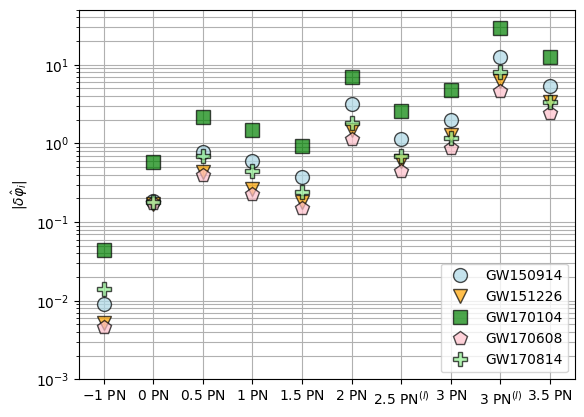

In [9]:
markers = ['o','v','s','p','P','D','H','d','D']
markercol = ['lightblue', 'orange', 'g', 'pink', 'lightgreen']

plt.legend(loc="lower right")
plt.grid()
plt.ylim(1e-3, 5e1)
plt.xlim(-0.5, 9.5)
plt.xticks(range(10), [r'$-1$ PN',r'$0$ PN', r'$0.5$ PN', r'$1$ PN', r'$1.5$ PN', r'$2$ PN', r'$2.5$ PN$^{(l)}$', r'$3$ PN', r'$3$ PN$^{(l)}$', r'$3.5$ PN'])
plt.grid(which='major',axis='both')
plt.grid(which='minor')
plt.yticks([1e-3,1e-2,1e-1,1e0,1e1])
plt.ylabel(r'$|\delta \hat \varphi_i|$')
plt.grid()
plt.plot(1,1)

### Loop over events
for idxe, event in enumerate(events_PI):
    plt.semilogy(range(len(params_PI)), [ul[event][par] for par in params_PI], linestyle='', marker=markers[idxe], markersize=10, mec='k', markerfacecolor=markercol[idxe], alpha=0.7, label=event)
plt.legend()

## Medians and symmetric 90% confidence intervals (Table V)

In [12]:
### Load pickled dictionary with medians and 90% CI values
dict_filename = "PGen_stats.pkl"
with open(dict_filename, 'rb') as stats_file:
    stats_dict = cPickle.load(stats_file)

    ### The layers of the dictionary are [event] [parameter] [model]
    for event in stats_dict.keys():
        print(event + "\n=========")

        parlist = []
        if event in events_PI:
            parlist += params_PI
        if event in events_PPI:
            parlist += params_PPI

        for param in parlist:
            print(" * " + param)
            for model in stats_dict[event][param].keys():
                stats = stats_dict[event][param][model]
                # Only print available data
                if stats[0] is not '-':
                    print('\t - %s: %s^{%s}_{%s} , GR @ %s%%' %(model, stats[0], stats[2], stats[1], stats[3]))

GW151012
 * dbeta_2
	 - IMRP: 0.3^{+3.8}_{-0.6} , GR @ 24%
 * dbeta_3
	 - IMRP: 3.3^{+3.6}_{-3.4} , GR @ 5.6%
 * dalpha_2
	 - IMRP: 0^{+14}_{-3} , GR @ 37%
 * dalpha_3
	 - IMRP: 5^{+81}_{-33} , GR @ 29%
 * dalpha_4
	 - IMRP: 6^{+24}_{-30} , GR @ 33%
GW170608
 * dphi_-2
	 - IMRP: -0.06^{+0.61}_{-0.35} , GR @ 60%
	 - SEOB: 0.10^{+0.27}_{-0.34} , GR @ 26%
 * dphi_0
	 - IMRP: -0.5^{+1.4}_{-1.6} , GR @ 73%
	 - SEOB: -0.9^{+1.8}_{-2.2} , GR @ 77%
 * dphi_1
	 - IMRP: -0.14^{+0.33}_{-0.33} , GR @ 76%
	 - SEOB: -0.16^{+0.38}_{-0.40} , GR @ 77%
 * dphi_2
	 - IMRP: -0.07^{+0.21}_{-0.20} , GR @ 72%
	 - SEOB: -0.09^{+0.24}_{-0.25} , GR @ 75%
 * dphi_3
	 - IMRP: 0.5^{+1.2}_{-1.2} , GR @ 26%
	 - SEOB: 0.6^{+1.6}_{-1.4} , GR @ 26%
 * dphi_4
	 - IMRP: -0.3^{+1.1}_{-1.1} , GR @ 67%
	 - SEOB: -0.4^{+1.3}_{-1.4} , GR @ 70%
 * dphi_5l
	 - IMRP: 0.09^{+0.42}_{-0.42} , GR @ 36%
	 - SEOB: 0.25^{+0.62}_{-0.54} , GR @ 23%
 * dphi_6
	 - IMRP: -0.11^{+0.84}_{-0.84} , GR @ 59%
	 - SEOB: -0.3^{+1.0}_{-1.0} , GR @ 6

<>:21: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:21: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
/tmp/ipython-input-1521046732.py:21: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if stats[0] is not '-':
